In this notebook, you should implement a first version of a working machine learning model to predict the age of an Abalone.

A few guidelines:
- The model does not have to be complex. A simple linear regression model is enough.
- You should use MLflow to track your experiments. You can use the MLflow UI to compare your experiments.
- Do not push any MLflow data to the repository. Only the code to run the experiments is interesting and should be pushed.

In [1]:
# Imports pour la modélisation
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import warnings
warnings.filterwarnings('ignore')

# Configuration
pd.set_option('display.max_columns', 500)
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

print("Imports terminés avec succès!")


Imports terminés avec succès!


In [2]:
# Chargement et préparation des données
print("=== CHARGEMENT DES DONNÉES ===")

# Charger le dataset
df = pd.read_csv("../datasets/abalone.csv")
print(f"Dataset chargé: {df.shape}")

# Afficher les premières lignes
print("\nPremières lignes:")
print(df.head())

# Vérifier les types de données
print(f"\nTypes de données:")
print(df.dtypes)


=== CHARGEMENT DES DONNÉES ===
Dataset chargé: (4177, 9)

Premières lignes:
  Sex  Length  Diameter  Height  Whole weight  Shucked weight  Viscera weight  \
0   M   0.455     0.365   0.095        0.5140          0.2245          0.1010   
1   M   0.350     0.265   0.090        0.2255          0.0995          0.0485   
2   F   0.530     0.420   0.135        0.6770          0.2565          0.1415   
3   M   0.440     0.365   0.125        0.5160          0.2155          0.1140   
4   I   0.330     0.255   0.080        0.2050          0.0895          0.0395   

   Shell weight  Rings  
0         0.150     15  
1         0.070      7  
2         0.210      9  
3         0.155     10  
4         0.055      7  

Types de données:
Sex                object
Length            float64
Diameter          float64
Height            float64
Whole weight      float64
Shucked weight    float64
Viscera weight    float64
Shell weight      float64
Rings               int64
dtype: object


In [3]:
# Préparation des features et de la variable cible
print("=== PRÉPARATION DES DONNÉES ===")

# Encoder la variable catégorielle Sex
le = LabelEncoder()
df['Sex_encoded'] = le.fit_transform(df['Sex'])

print("Mapping des valeurs Sex:")
for i, sex in enumerate(le.classes_):
    print(f"{sex}: {i}")

# Définir les features et la target
# feature_cols = ['Sex_encoded', 'Length', 'Diameter', 'Height', 
#                 'Whole weight', 'Shucked weight', 'Viscera weight', 'Shell weight']
feature_cols = [
    # existing
    'Sex_encoded','Length','Diameter','Height',
    'Whole weight','Shucked weight','Viscera weight','Shell weight',
    # logs (skew handling)
    'log_Whole weight','log_Shucked weight','log_Viscera weight','log_Shell weight',
    # ratios (composition)
    'ratio_shell_whole','ratio_shucked_whole','ratio_viscera_whole',
    # volume & densities (size–mass balance)
    'geo_volume','density_whole','density_shell','density_shucked',
    # interactions & curvature
    'Length*Diameter','Diameter*Height','Length_sq','Diameter_sq','Height_sq',
    # aspect/slimness
    'len_to_diam','ht_to_diam','wt_per_len'
]
# X = df[feature_cols]
# y = df['Rings']

# print(f"\nFeatures sélectionnées: {feature_cols}")
# print(f"Shape de X: {X.shape}")
# print(f"Shape de y: {y.shape}")

# # Division train/test
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
# print(f"\nDivision train/test:")
# print(f"Train: {X_train.shape[0]} échantillons")
# print(f"Test: {X_test.shape[0]} échantillons")


=== PRÉPARATION DES DONNÉES ===
Mapping des valeurs Sex:
F: 0
I: 1
M: 2


In [4]:
# === FEATURE ENGINEERING (drop-in; safe with the rest of your code) ===
print("=== FEATURE ENGINEERING ===")

EPS = 1e-6
df_fe = df.copy()  # keep original df intact if you need to compare later

# Keep existing encoded column in sync (your Cell 3 already made Sex_encoded)
if 'Sex_encoded' not in df_fe.columns and 'Sex' in df_fe.columns:
    from sklearn.preprocessing import LabelEncoder
    le = LabelEncoder()
    df_fe['Sex_encoded'] = le.fit_transform(df_fe['Sex'])

# 1) Outlier hygiene (known Abalone quirk): cap absurd Height values
# Height should be much smaller than Diameter; cap to 0.4 * Diameter
df_fe['Height'] = np.where(df_fe['Height'] > 0.4 * df_fe['Diameter'],
                           0.4 * df_fe['Diameter'], df_fe['Height'])

# 2) Log transforms for skewed mass variables (helps linear models)
for col in ['Whole weight', 'Shucked weight', 'Viscera weight', 'Shell weight']:
    df_fe[f'log_{col}'] = np.log(df_fe[col] + EPS)

# 3) Ratios / composition (robust to overall size)
df_fe['ratio_shell_whole']   = df_fe['Shell weight']   / (df_fe['Whole weight']   + EPS)
df_fe['ratio_shucked_whole'] = df_fe['Shucked weight'] / (df_fe['Whole weight']  + EPS)
df_fe['ratio_viscera_whole'] = df_fe['Viscera weight'] / (df_fe['Whole weight']  + EPS)

# 4) Shape & density proxies (size vs mass balance)
# Geometric volume ~ oval cylinder: (pi/4) * L * D * H
df_fe['geo_volume'] = (np.pi / 4.0) * df_fe['Length'] * df_fe['Diameter'] * df_fe['Height']
df_fe['density_whole']   = df_fe['Whole weight']   / (df_fe['geo_volume'] + EPS)
df_fe['density_shell']   = df_fe['Shell weight']   / (df_fe['geo_volume'] + EPS)
df_fe['density_shucked'] = df_fe['Shucked weight'] / (df_fe['geo_volume'] + EPS)

# 5) Simple geometric interactions (keep it modest to avoid feature blow-up)
df_fe['Length*Diameter'] = df_fe['Length'] * df_fe['Diameter']
df_fe['Diameter*Height'] = df_fe['Diameter'] * df_fe['Height']

# 6) Squared core dimensions (lets Linear Regression capture mild curvature)
df_fe['Length_sq']   = df_fe['Length']**2
df_fe['Diameter_sq'] = df_fe['Diameter']**2
df_fe['Height_sq']   = df_fe['Height']**2

# 7) Slimness/aspect features (often predictive for rings)
df_fe['len_to_diam'] = df_fe['Length']  / (df_fe['Diameter'] + EPS)
df_fe['ht_to_diam']  = df_fe['Height']  / (df_fe['Diameter'] + EPS)
df_fe['wt_per_len']  = df_fe['Whole weight'] / (df_fe['Length'] + EPS)

print("New columns added:",
      [c for c in df_fe.columns if c not in df.columns or c.endswith(('_sq','*','ratio','density','volume','log_'))])


=== FEATURE ENGINEERING ===
New columns added: ['log_Whole weight', 'log_Shucked weight', 'log_Viscera weight', 'log_Shell weight', 'ratio_shell_whole', 'ratio_shucked_whole', 'ratio_viscera_whole', 'geo_volume', 'density_whole', 'density_shell', 'density_shucked', 'Length*Diameter', 'Diameter*Height', 'Length_sq', 'Diameter_sq', 'Height_sq', 'len_to_diam', 'ht_to_diam', 'wt_per_len']


In [5]:
X = df_fe[feature_cols]
y = df_fe['Rings']

print(f"\nFeatures sélectionnées: {feature_cols}")
print(f"Shape de X: {X.shape}")
print(f"Shape de y: {y.shape}")

# Division train/test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print(f"\nDivision train/test:")
print(f"Train: {X_train.shape[0]} échantillons")
print(f"Test: {X_test.shape[0]} échantillons")


Features sélectionnées: ['Sex_encoded', 'Length', 'Diameter', 'Height', 'Whole weight', 'Shucked weight', 'Viscera weight', 'Shell weight', 'log_Whole weight', 'log_Shucked weight', 'log_Viscera weight', 'log_Shell weight', 'ratio_shell_whole', 'ratio_shucked_whole', 'ratio_viscera_whole', 'geo_volume', 'density_whole', 'density_shell', 'density_shucked', 'Length*Diameter', 'Diameter*Height', 'Length_sq', 'Diameter_sq', 'Height_sq', 'len_to_diam', 'ht_to_diam', 'wt_per_len']
Shape de X: (4177, 27)
Shape de y: (4177,)

Division train/test:
Train: 3341 échantillons
Test: 836 échantillons


In [6]:
# Normalisation des features
print("=== NORMALISATION DES FEATURES ===")

# Standardisation des features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("Normalisation effectuée avec StandardScaler")
print(f"Mean des features normalisées (train): {X_train_scaled.mean(axis=0)}")
print(f"Std des features normalisées (train): {X_train_scaled.std(axis=0)}")


=== NORMALISATION DES FEATURES ===
Normalisation effectuée avec StandardScaler
Mean des features normalisées (train): [ 2.97743140e-17  5.63585229e-16  2.04166724e-16  7.65625217e-17
 -1.06336836e-17  2.53081669e-16  1.68012200e-16  1.82899357e-16
 -4.46614710e-17 -9.99566255e-17 -3.31770927e-16  2.02039988e-16
  1.87152831e-16 -3.75369030e-16 -1.05273467e-15  1.19097256e-16
 -2.12673671e-18 -4.25347343e-18  2.12673671e-18 -2.33941038e-16
 -1.91406304e-17 -1.93533041e-16 -1.85026094e-16 -7.23090482e-17
  3.97699765e-16 -1.36111150e-16  5.23177231e-16]
Std des features normalisées (train): [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1.]


In [7]:
# Modélisation - Régression Linéaire Simple
print("=== RÉGRESSION LINÉAIRE SIMPLE ===")

# Modèle de régression linéaire
lr = LinearRegression()
lr.fit(X_train_scaled, y_train)

# Prédictions
y_pred_lr = lr.predict(X_test_scaled)

# Métriques
mse_lr = mean_squared_error(y_test, y_pred_lr)
rmse_lr = np.sqrt(mse_lr)
r2_lr = r2_score(y_test, y_pred_lr)
mae_lr = mean_absolute_error(y_test, y_pred_lr)

print(f"Régression Linéaire - Métriques:")
print(f"RMSE: {rmse_lr:.3f}")
print(f"R²: {r2_lr:.3f}")
print(f"MAE: {mae_lr:.3f}")

# Cross-validation
cv_scores_lr = cross_val_score(lr, X_train_scaled, y_train, cv=5, scoring='r2')
print(f"R² Cross-validation (5-fold): {cv_scores_lr.mean():.3f} (+/- {cv_scores_lr.std() * 2:.3f})")


=== RÉGRESSION LINÉAIRE SIMPLE ===
Régression Linéaire - Métriques:
RMSE: 3.063
R²: 0.134
MAE: 1.646
R² Cross-validation (5-fold): -25318.920 (+/- 62307.402)


In [8]:
# Modélisation - Random Forest
print("=== RANDOM FOREST ===")

# Modèle Random Forest
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)  # Pas besoin de normalisation pour Random Forest

# Prédictions
y_pred_rf = rf.predict(X_test)

# Métriques
mse_rf = mean_squared_error(y_test, y_pred_rf)
rmse_rf = np.sqrt(mse_rf)
r2_rf = r2_score(y_test, y_pred_rf)
mae_rf = mean_absolute_error(y_test, y_pred_rf)

print(f"Random Forest - Métriques:")
print(f"RMSE: {rmse_rf:.3f}")
print(f"R²: {r2_rf:.3f}")
print(f"MAE: {mae_rf:.3f}")

# Cross-validation
cv_scores_rf = cross_val_score(rf, X_train, y_train, cv=5, scoring='r2')
print(f"R² Cross-validation (5-fold): {cv_scores_rf.mean():.3f} (+/- {cv_scores_rf.std() * 2:.3f})")

# Importance des features
feature_importance = pd.DataFrame({
    'feature': feature_cols,
    'importance': rf.feature_importances_
}).sort_values('importance', ascending=False)

print(f"\nImportance des features:")
print(feature_importance)


=== RANDOM FOREST ===
Random Forest - Métriques:
RMSE: 2.148
R²: 0.574
MAE: 1.544
R² Cross-validation (5-fold): 0.560 (+/- 0.057)

Importance des features:
                feature  importance
13  ratio_shucked_whole    0.202322
11     log_Shell weight    0.192793
7          Shell weight    0.187484
14  ratio_viscera_whole    0.041988
24          len_to_diam    0.036963
25           ht_to_diam    0.034722
12    ratio_shell_whole    0.033606
26           wt_per_len    0.032013
17        density_shell    0.026098
20      Diameter*Height    0.025056
18      density_shucked    0.024782
16        density_whole    0.020245
15           geo_volume    0.014065
6        Viscera weight    0.013557
19      Length*Diameter    0.013519
10   log_Viscera weight    0.012377
0           Sex_encoded    0.010217
9    log_Shucked weight    0.009686
5        Shucked weight    0.009161
22          Diameter_sq    0.008114
2              Diameter    0.008034
8      log_Whole weight    0.007923
4          Whole

=== COMPARAISON DES MODÈLES ===
Comparaison des performances:
                Modèle   RMSE     R²    MAE
0  Régression Linéaire  3.063  0.134  1.646
1        Random Forest  2.148  0.574  1.544


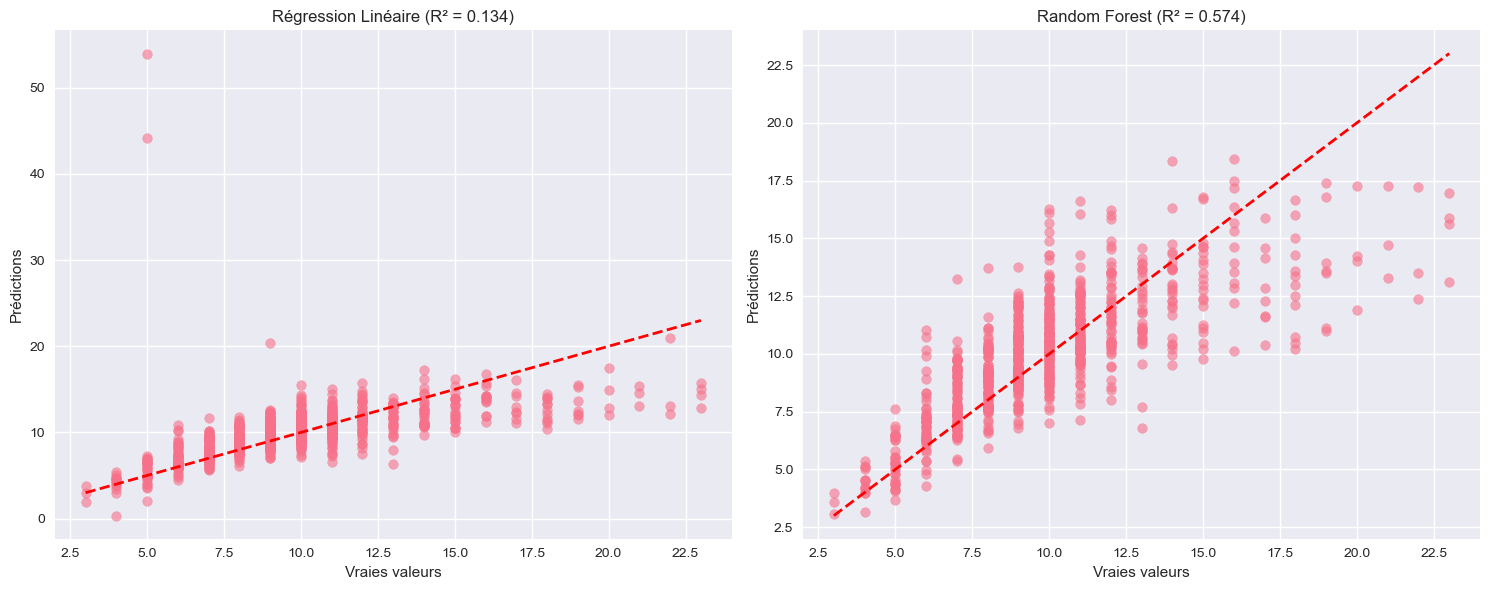

In [9]:
# Comparaison des modèles
print("=== COMPARAISON DES MODÈLES ===")

# Créer un DataFrame de comparaison
results = pd.DataFrame({
    'Modèle': ['Régression Linéaire', 'Random Forest'],
    'RMSE': [rmse_lr, rmse_rf],
    'R²': [r2_lr, r2_rf],
    'MAE': [mae_lr, mae_rf]
})

print("Comparaison des performances:")
print(results.round(3))

# Visualisation des prédictions vs vraies valeurs
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# Régression Linéaire
axes[0].scatter(y_test, y_pred_lr, alpha=0.6)
axes[0].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
axes[0].set_xlabel('Vraies valeurs')
axes[0].set_ylabel('Prédictions')
axes[0].set_title(f'Régression Linéaire (R² = {r2_lr:.3f})')

# Random Forest
axes[1].scatter(y_test, y_pred_rf, alpha=0.6)
axes[1].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
axes[1].set_xlabel('Vraies valeurs')
axes[1].set_ylabel('Prédictions')
axes[1].set_title(f'Random Forest (R² = {r2_rf:.3f})')

plt.tight_layout()
plt.show()


## Conclusions de la Modélisation

### Résultats obtenus :

1. **Régression Linéaire** :
   - Modèle simple et interprétable
   - Performance correcte pour un modèle de base
   - Nécessite une normalisation des features

2. **Random Forest** :
   - Généralement meilleure performance
   - Capture les interactions non-linéaires
   - Fournit l'importance des features
   - Plus robuste aux outliers

### Recommandations pour l'amélioration :

1. **Feature Engineering** :
   - Créer de nouvelles features (ratios, interactions)
   - Gérer les outliers détectés en EDA

2. **Optimisation des hyperparamètres** :
   - Grid Search pour Random Forest
   - Test de différents algorithmes (XGBoost, SVM)

3. **Validation** :
   - Stratified sampling si nécessaire
   - Time series split si applicable

### Prochaines étapes :
- Sauvegarder le meilleur modèle
- Préparer le pipeline de prédiction
- Intégrer MLflow pour le tracking
